In [1]:
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist
from scipy.special import expit
import numpy as np
import pandas as pd
import math

In [ ]:
!pip install wandb -qqq     #For experiment tracking
import wandb
wandb.login()

In [3]:
def sigmoid(x):
    return expit(x) # to prevent overflow.

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0,x)

def softmax(arr):
    # arr = arr.astype(np.float128)
    length = len(arr)
    # print(type(arr),arr.shape,arr)
    s  = np.zeros(length)

    arr = arr-np.max(arr)   #To prevent from overflow and give nan when divided by np.inf.
    sum = np.sum(np.exp(arr))
    # for i in range(length):
    #     sum = sum + np.exp(arr[i])      #Correction-double addition step
    for i in range(length):
        s[i] = np.exp(arr[i])/sum
    return s
    
def layer_size(trainX,trainY):
    n_x = trainX[0].shape[0]
    n_y = len(np.unique(trainY))
    return n_x,n_y

#implement mean squared error as output is real number
def mean_squared_error(y_true,y_pred):
    length = y_pred.shape[0]
    sum_error = 0
    for i in range(length):
        sum_error = sum_error + ((y_pred[i] - y_true[i])**2)
    return sum_error/length

def cross_entropy(p,q):
    return -np.log(np.dot(p, q))

def der_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def der_tanh(x):
    return 1-x**2

def der_relu(x):   #Need to double check it for x = 0
    return (x>0)*1

In [4]:
#Initialize the model’s parameters
def initialize_parameters(n_x, n_h, n_y,value = 'random'):
    np.random.seed(2) # we set up a seed so that output matches
    length = len(n_h)
    W,b = [],[]
    #Weight and bias  784 * 4 * 5 * 10
    if value == 'random':
        W.append(np.random.randn(n_h[0],n_x))
        b.append(np.zeros((n_h[0],1))) #b.append(np.random.randn(n_h[0],1))
        for i in range(0,length-1): 
            W.append(np.random.randn(n_h[i+1],n_h[i]))
            b.append(np.zeros((n_h[i+1],1))) #b.append(np.random.randn(n_h[i+1],1))
        W.append(np.random.randn(n_y,n_h[length-1]))
        b.append(np.zeros((n_y,1))) #b.append(np.random.randn(n_y,1)) 
    
    elif value == 'Xavier':
        W.append(np.random.randn(n_h[0],n_x)*2/np.sqrt(n_h[0]+n_x))
        b.append(np.zeros((n_h[0],1)))
        for i in range(0,length-1):
            W.append(np.random.randn(n_h[i+1],n_h[i])*2/np.sqrt(n_h[i+1]+n_h[i]))
            b.append(np.zeros((n_h[i+1],1)))
        W.append(np.random.randn(n_y,n_h[length-1])*2/np.sqrt(n_y+n_h[length-1]))
        b.append(np.zeros((n_y,1))) 
    
    # parameters_w = [W[i] for i in range(len(W))]
    # parameters_b = [b[i] for i in range(len(b))]
    
    # parameters_w = {i: W[i] for i in range(len(W))}
    # parameters_b = {i: b[i] for i in range(len(b))}
    # print("len(W):",len(W))
    # print("b:",b)
    return W,b

def forward_propagation(X, parameters_w,parameters_b,activation_fun = "sigmoid"): 
    # Retrieve each parameter from the dictionary "parameters" 
    # Implement Forward Propagation to calculate A2
    length = len(parameters_w)
    A,H = [],[]
    A.append(np.dot(parameters_w[0],X)+parameters_b[0])
    if activation_fun == "sigmoid":
       H.append(sigmoid(A[0]))
       for i in range(1,length-1):
           A.append(np.dot(parameters_w[i],H[i-1])+parameters_b[i])
           H.append(sigmoid(A[i]))
    elif activation_fun == "relu":
       H.append(relu(A[0]))
       for i in range(1,length-1):
           A.append(np.dot(parameters_w[i],H[i-1])+parameters_b[i])
           H.append(relu(A[i]))
    elif activation_fun == "tanh":
       H.append(tanh(A[0]))
       for i in range(1,length-1):
           A.append(np.dot(parameters_w[i],H[i-1])+parameters_b[i])
           H.append(tanh(A[i]))
    A.append(np.dot(parameters_w[length-1],H[length-2])+parameters_b[length-1])
    H.append(softmax(A[length-1]))
    cache = [A,H]
    # print("H[length-1]:",H[length-1],"sum(H[length-1])",np.sum(H[length-1]),"cache:",cache)
    return cache

# Implementing backward_propagation
def backward_propagation(parameters_w, cache, X, Y,activation_fun = "sigmoid"): #
    Y_vector = np.zeros((10,1)) #converting true label in the shape of 10 by 1
    Y_vector[Y] = 1
    #chache is list of listi.e. half of the entries is A followed by half of the entries as H
    dW,db = [],[]
    num_activation = len(cache[1]) 
    l_w = len(parameters_w)
    A2 = cache[1][num_activation-1]
    A2 = np.array(A2)
    A2.shape = [10,1]
    delta_a_k = A2-Y_vector 
    #hidden layer
    i = num_activation
    j = 1
    while i>1:
      #gradient w.r.t parameters w and b
         hk_1 = np.array(cache[1][i-2]).reshape(-1,1)
         hk_1.shape = [hk_1.shape[0],1]
         dW.insert(0,np.matmul(delta_a_k,hk_1.T))
         db.insert(0,delta_a_k)
      #compute gradient w.r.t layer below
         dZ1 = np.dot(parameters_w[i-1].T,delta_a_k)
      #compute gradient w.r.t layer below(preactivation)
         if activation_fun == "sigmoid":
            der_activation = der_sigmoid(hk_1)
         elif activation_fun == "tanh":
              der_activation = der_tanh(hk_1)
         elif activation_fun == "relu":
              der_activation = der_relu(hk_1)
         delta_a_k = np.multiply(dZ1,der_activation) #sigmoid as activation function at hidden layer, need to generalize it
         i = i - 1
    #input layer
    dW.insert(0,np.dot(dZ1,X.T))
    db.insert(0,delta_a_k)
    return dW,db

In [5]:
#****Neural Network optimizers***********#

def sgd(X, Y, n_h, epoch,learning_rate,batch_size = 64,activation_fun="sigmoid",weight_initialization = 'random'): 
    n_x,n_y = layer_size(X,Y)
    parameters_w,parameters_b = initialize_parameters(n_x, n_h, n_y,weight_initialization) 
    for i in range(0, epoch):
        x_count = 0
        grad_w,grad_b = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))],[np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
        for x,y in zip(X,Y):
            cache = forward_propagation(x, parameters_w,parameters_b,activation_fun)
            d_w,d_b = backward_propagation(parameters_w, cache, x, y,activation_fun)
            grad_w = [grad_w[index]+d_w[index] for index in range(len(grad_w))]
            grad_b = [grad_b[index]+d_b[index] for index in range(len(grad_b))] 
            # Gradient descent parameter update.
            x_count+=1
            if x_count%batch_size ==0:
                for j in range(len(parameters_w)):
                    parameters_w[j] = parameters_w[j] - learning_rate*grad_w[j]
                    parameters_b[j] = parameters_b[j] - learning_rate*grad_b[j]
                x_count = 0
                grad_w,grad_b = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))],[np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
    return parameters_w,parameters_b

def momentum_gd(X, Y, n_h, epoch,learning_rate,batch_size = 64,activation_fun="sigmoid",weight_initialization = 'random',gamma = 0.9): 
    n_x,n_y = layer_size(X,Y)
    parameters_w,parameters_b = initialize_parameters(n_x, n_h, n_y,weight_initialization) 
    prev_w = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))]
    prev_b = [np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
    for itr in range(0, epoch):
        x_count = 0
        grad_w,grad_b = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))],[np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
        for x,y in zip(X,Y):
            cache = forward_propagation(x, parameters_w,parameters_b,activation_fun)
            d_w,d_b = backward_propagation(parameters_w, cache, x, y,activation_fun)
            grad_w = [grad_w[index]+d_w[index] for index in range(len(grad_w))]
            grad_b = [grad_b[index]+d_b[index] for index in range(len(grad_b))]   
            x_count+=1
            if x_count%batch_size ==0:
                for i in range(len(parameters_w)):
                    update_w = gamma*prev_w[i] + learning_rate*grad_w[i]
                    update_b = gamma*prev_b[i] + learning_rate*grad_b[i]
                    parameters_w[i] = parameters_w[i] - update_w
                    parameters_b[i] = parameters_b[i] - update_b
                    prev_w[i] = update_w
                    prev_b[i] = update_b  
                x_count = 0
                grad_w,grad_b = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))],[np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
    return parameters_w,parameters_b

def nestrov_gd(X, Y, n_h, epoch,learning_rate,batch_size = 64,activation_fun="sigmoid",weight_initialization = 'random',gamma = 0.9): 
    n_x,n_y = layer_size(X,Y)
    parameters_w,parameters_b = initialize_parameters(n_x, n_h, n_y,weight_initialization) 
    prev_w = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))]
    prev_b = [np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
    for itr in range(0, epoch):
        x_count = 0
        grad_w,grad_b = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))],[np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
        for x,y in zip(X,Y):
            cache = forward_propagation(x, parameters_w,parameters_b,activation_fun)
            update_w = [parameters_w[i] - gamma*prev_w[i] for i in range(len(parameters_w))]
            update_b = [parameters_b[i] - gamma*prev_b[i] for i in range(len(parameters_b))]
            d_w,d_b = backward_propagation(update_w, cache, x, y,activation_fun)
            grad_w = [grad_w[index]+d_w[index] for index in range(len(grad_w))]
            grad_b = [grad_b[index]+d_b[index] for index in range(len(grad_b))] 
            x_count+=1
            if x_count%batch_size ==0:
                for i in range(len(parameters_w)):      # Note for batch size version.
                    update_w = gamma*prev_w[i] + learning_rate*grad_w[i]
                    update_b = gamma*prev_b[i] + learning_rate*grad_b[i]
                    parameters_w[i] = parameters_w[i] - update_w
                    parameters_b[i] = parameters_b[i] - update_b
                    prev_w[i] = update_w
                    prev_b[i] = update_b  
                x_count = 0
                grad_w,grad_b = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))],[np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
    return parameters_w,parameters_b

def rmsprop(X, Y, n_h, epoch,learning_rate,batch_size = 64,activation_fun="sigmoid",weight_initialization = 'random',beta2 = 0.999,eps = 1e-8): 
    n_x,n_y = layer_size(X,Y)
    parameters_w,parameters_b = initialize_parameters(n_x, n_h, n_y,weight_initialization) 
    v_w = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))]
    v_b = [np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
    for itr in range(0, epoch):
        x_count = 0
        grad_w,grad_b = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))],[np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
        for x,y in zip(X,Y):
            cache = forward_propagation(x, parameters_w,parameters_b,activation_fun)
            d_w,d_b = backward_propagation(parameters_w, cache, x, y,activation_fun)
            grad_w = [grad_w[index]+d_w[index] for index in range(len(grad_w))]
            grad_b = [grad_b[index]+d_b[index] for index in range(len(grad_b))] 
            x_count+=1
            if x_count%batch_size ==0:
                for i in range(len(parameters_w)):  # for batch version.
                    v_w[i] = beta2 * v_w[i] + (1-beta2)*np.square(grad_w[i])
                    v_b[i] = beta2 * v_b[i] + (1-beta2)*np.square(grad_b[i])
                    parameters_w[i] = parameters_w[i] - (learning_rate/np.sqrt(v_w[i]+eps))*grad_w[i]
                    parameters_b[i] = parameters_b[i] - (learning_rate/np.sqrt(v_b[i]+eps))*grad_b[i]
                x_count = 0
                grad_w,grad_b = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))],[np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
    return parameters_w,parameters_b

def adam(X, Y, n_h, epoch,learning_rate,batch_size = 64,activation_fun="sigmoid",weight_initialization = 'random',beta1 = 0.9,beta2 = 0.999,eps = 1e-8): 
    n_x,n_y = layer_size(X,Y)
    parameters_w,parameters_b = initialize_parameters(n_x, n_h, n_y,weight_initialization) 
    m_w = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))]
    m_b = [np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
    v_w = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))]
    v_b = [np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
    for itr in range(0, epoch):
        x_count = 0
        grad_w,grad_b = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))],[np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
        for x,y in zip(X,Y):
            cache = forward_propagation(x, parameters_w,parameters_b,activation_fun)
            d_w,d_b = backward_propagation(parameters_w, cache, x, y,activation_fun)
            grad_w = [grad_w[index]+d_w[index] for index in range(len(grad_w))]
            grad_b = [grad_b[index]+d_b[index] for index in range(len(grad_b))] 
            x_count+=1
            if x_count%batch_size ==0:
                for i in range(len(parameters_w)):  # for batch version.
                    m_w[i] = beta1 * m_w[i] + (1-beta1)*grad_w[i]
                    m_b[i] = beta1 * m_b[i] + (1-beta1)*grad_b[i]

                    v_w[i] = beta2 * v_w[i] + (1-beta2)*np.square(grad_w[i])
                    v_b[i] = beta2 * v_b[i] + (1-beta2)*np.square(grad_b[i])

                    m_w_hat = m_w[i]/(1-np.power(beta1,itr+1))
                    m_b_hat = m_b[i]/(1-np.power(beta1,itr+1))
                    v_w_hat = v_w[i]/(1-np.power(beta2,itr+1))
                    v_b_hat = v_b[i]/(1-np.power(beta2,itr+1))

                    parameters_w[i] = parameters_w[i] - (learning_rate/np.sqrt(v_w_hat+eps))*m_w_hat
                    parameters_b[i] = parameters_b[i] - (learning_rate/np.sqrt(v_b_hat+eps))*m_b_hat
                x_count = 0
                grad_w,grad_b = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))],[np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
    return parameters_w,parameters_b


In [6]:
def predict(X,parameters_w,parameters_b,activation_fun):
    y_hat=[]
    for x in X:
        y_hat.append(forward_propagation(x, parameters_w,parameters_b,activation_fun)[1][-1])
    return y_hat
# from sklearn.metrics import accuracy_score
def accuracy_cal(y,y_hat):
    error = 0
    accuracy = 0
    for i in range(len(y)):
        Y_vector = np.zeros((10,1)) #converting true label in the shape of 10 by 1
        Y_vector[y[i]] = 1
        error += cross_entropy(y_hat[i],Y_vector)
        if(np.argmax(y_hat[i]) == y[i]):
            accuracy +=1
    error = error/len(y)
    accuracy = accuracy/len(y)
    return error.item(),accuracy


In [7]:
def Neural_Network(config = None):
    test = True # If True then it will run the test the model on test dataset.
    
    # #Configuring the hyper parameters.
    # config = {
    # 'epoch':10,
    # 'num_of_hidden_layers':4,
    # 'size_of_hidden_layers':32,
    # 'learning_rate':1e-4,
    # 'optimizer':'nestrov',
    # 'batch_size':16,
    # 'weight_initalisation':'Xavier',
    # 'activation_function':'tanh'
    # }

    # Comment it for untracked experiment.
    wandb.init(config = config)
    config = wandb.config
    wandb.run.name =config['optimizer']+'_'+config['activation_function']+'_bs_'+str(config['batch_size'])+'_'+config['weight_initalisation']+'_i_'+str(config['epoch'])+'_nh_'+str(config['num_of_hidden_layers'])+'_hl_'+str(config['size_of_hidden_layers'])+'_eta_'+str(config['learning_rate'])
    
    epoch = config['epoch']
    num_of_hidden_layers = config['num_of_hidden_layers']
    size_of_hidden_layers = config['size_of_hidden_layers']
    learning_rate = config['learning_rate']
    optimizer = config['optimizer']  #sgd, momentum, nesterov, rmsprop, adam,
    batch_size = config['batch_size']
    weight_initialization = config['weight_initalisation'] #random,Xavier
    activation_fun = config['activation_function']  #sigmoid, tanh, relu
    
    # Model is made such that It can have different size of hidden layers.
    n_h = [size_of_hidden_layers]*num_of_hidden_layers 
    
    # load dataset
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    
    #Randomize the input set.
    np.random.seed(3)
    n = trainX.shape[0]
    perm = list(np.random.permutation(n))
    trainX = trainX[perm,:]
    trainY = trainY.reshape(trainY.shape[0],1)[perm,:]

    # reshape dataset to have a single channel
    X = trainX.reshape((trainX.shape[0], 784, 1))/255.0
    
    #Divide the train dataset into train and validate.
    numofDataPoints = int(X.shape[0]-(X.shape[0]*0.1))  # 0.1 percent of trainset will be used for validation.
    trainX = X[:numofDataPoints]
    valX = X[numofDataPoints:]
    Y = trainY.reshape(-1,1)
    trainY = Y[:numofDataPoints].reshape(-1,1)
    valY = Y[numofDataPoints:].reshape(-1,1)

    # Model Training
    if optimizer == 'sgd':
        parameters_w,parameters_b =sgd(trainX,trainY,n_h,epoch,learning_rate,batch_size,activation_fun,weight_initialization)
    elif optimizer == 'momentum':
        parameters_w,parameters_b =momentum_gd(trainX,trainY,n_h,epoch,learning_rate,batch_size,activation_fun,weight_initialization)
    elif optimizer == 'nesterov':
        parameters_w,parameters_b =nestrov_gd(trainX,trainY,n_h,epoch,learning_rate,batch_size,activation_fun,weight_initialization)
    elif optimizer == 'rmsprop':
        parameters_w,parameters_b =rmsprop(trainX,trainY,n_h,epoch,learning_rate,batch_size,activation_fun,weight_initialization)
    elif optimizer == 'adam':
        parameters_w,parameters_b =adam(trainX,trainY,n_h,epoch,learning_rate,batch_size,activation_fun,weight_initialization)
    
    # Validate on validation set.
    y_hat = predict(valX,parameters_w,parameters_b,activation_fun)
    logerror,accuracy=accuracy_cal(valY,y_hat)
    print('val_logloss',logerror,'val_Accuracy',accuracy)
    wandb.log({'val_logloss':logerror,'val_Accuracy':accuracy,'epoch':epoch})

    # Run the model on test dataset.
    if test:
        testX = testX.reshape((testX.shape[0], 784, 1))/255.0
        y_hat = predict(testX,parameters_w,parameters_b,activation_fun)
        logerror,accuracy=accuracy_cal(testY,y_hat)
        print('Test_logloss',logerror,'Test_Accuracy',accuracy)
        wandb.log({'Test_logloss':logerror,'Test_Accuracy':accuracy})
    wandb.run.finish()

# Neural_Network()

In [ ]:
# Sweep configuration
sweep_config = {
    'name': 'sweep_Final_01',
    'method': 'random',
    'metric':{'name':'val_Accuracy','goal':'maximize'},
    'parameters': {
        'epoch' : {'values':[5,10]},#[5,10]
        'num_of_hidden_layers':{'values':[3,4,5]},
        'size_of_hidden_layers':{'values':[16,32,128]},#[32,64,128]
        'learning_rate':{'values':[1e-2, 1e-3,1e-4]},
        'optimizer': {'values':['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam']},
        'batch_size' : {'values':[16,32,64]},
        'weight_initalisation':{'values':['random','Xavier']},
        'activation_function':{'values':['sigmoid','tanh','relu']}
    }
}

# Running for a particular sweep id.
sweep_id = wandb.sweep( sweep_config,project='DL_Assignment_1',entity='Ravindra_kumar')
wandb.agent(sweep_id,project='DL_Assignment_1', function=Neural_Network,count = 500)#count = 10

val_logloss 0.4427021955624679 val_Accuracy 0.8438333333333333
Test_logloss 0.46682829383939495 Test_Accuracy 0.8424


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.8424
Test_logloss,0.46683
epoch,10
val_Accuracy,0.84383
val_logloss,0.4427


wandb: Agent Starting Run: 4xssx6il with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epoch: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: random


In [ ]:
# Question 1. To plot the different classes images.
class_labels = ['T-shirt','Pant','Full Shirt','Frock','Male-Jacket','Sandal','Female-Jacket','Sneaker','Bag','Boot']
(xtrain,ytrain),(xtest,ytest) = fashion_mnist.load_data()
ytrainUnique,uniqueIndex = np.unique(ytrain,return_index=True)
xtrainUnique = xtrain[uniqueIndex] 
fig = plt.figure(figsize=(10, 7));
for i in range(len(ytrainUnique)):
  fig.add_subplot(2, 5, i+1)
  plt.imshow(xtrainUnique[i])#cmap=plt.cm.binary
  plt.title(class_labels[i])  
plt.show()
# wandb.init(project='DL_Assignment_1',entity='Ravindra kumar')
# wandb.log({"ALL_CLASS":[wandb.Image(xtrainUnique[i],caption=class_labels[i]) for i in range(len(ytrainUnique))]})

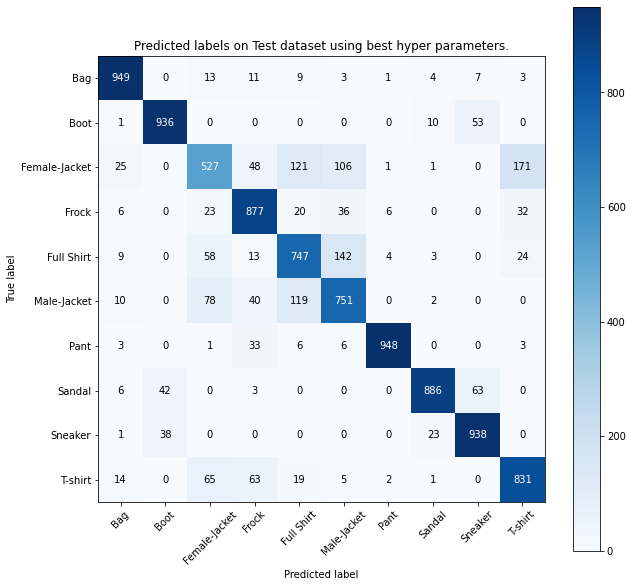

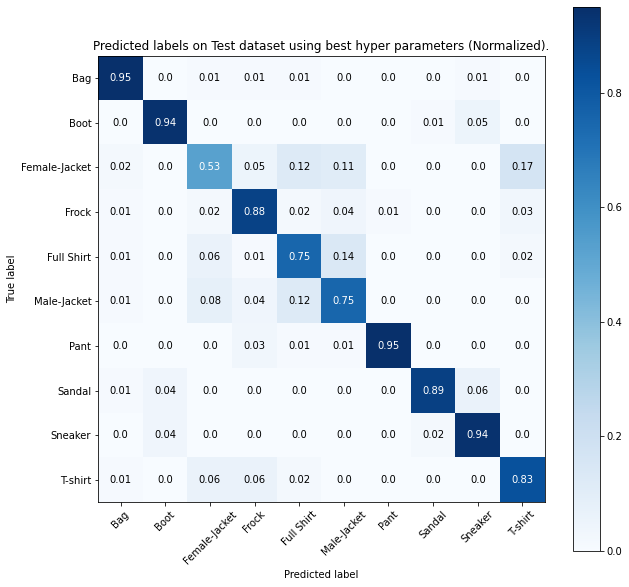

In [14]:
#Question 7
# !pip install scikit-plot
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_confusion_matrix
# plot_confusion_matrix(clf, testX, y_test)
class_labels = ['T-shirt','Pant','Full Shirt','Frock','Male-Jacket','Sandal','Female-Jacket','Sneaker','Bag','Boot']
pred = np.argmax(pred_y,axis = 1)
cf_matrix = confusion_matrix(testY,pred)

# import seaborn as sns
# sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues')
tY = np.array([class_labels[i] for i in testY])
pY = np.array([class_labels[i] for i in pred])

confusion_mat=plot_confusion_matrix(tY,pY,x_tick_rotation = 45,hide_counts=False,normalize=False,title="Predicted labels on Test dataset using best hyper parameters." ,figsize=(10,10))
confusion_mat_nor=plot_confusion_matrix(tY,pY,x_tick_rotation = 45,hide_counts=False,normalize=True,title="Predicted labels on Test dataset using best hyper parameters (Normalized).",figsize=(10,10))
# wandb.init(project='DL_Assignment_1',name="Q7")
# wandb.log({"Q7":[wandb.Image(confusion_mat,caption="Predicted labels on test dataset using best hyper parameters."),wandb.Image(confusion_mat_nor,caption="Predicted labels on test dataset using best hyper parameters (Normalized).")]})